# Part 7: Complete linear regression code


**Complete code and summary of linear regression results**

   In the part 0 we did some basic prepossing. Parts 1-6 contained further data processing and linear regession predictions.

    Part 1: Perform data processing as in part 0. Linear regression on the 34 numerical features gives RMSE 0.14890 in kaggle.
    
    Part 2: Perform data processing as in part 1, then transform 22 categorical features into numerical features. Linear regression on the resulting 56 numerical features gives RMSE 0.14555.
    
    Part 3: Perform data processing as in part 2, then remove categorical features which we believe contain little information, and one-hot encode the remaining categorical features. Linear regression on the result gives RMSE 0.14227.

Parts 4,5,6 contain investigations of weak correlations, strong correlations and outliers, with several submissions per part. Before summarising the results for these we first give the code in its entirety, with convenient parameters so that we can easily alter the different components.

One thing to note is that calculation errors are possible, which _may_ generate a small number of erreonous predictions. We replace these erreonous predictions with the average of the other house prices. This approach, while unscientific, should not substantially affect our RMSE score if only a small number of these values exist.

After basic data preprocessing:
Number of numeric features = 34
Number of categorical features = 45

After numerical transformations of some categorical features:
Number of numeric features = 43
Number of categorical features = 36

After removing categorical features with little information:
Number of numeric features = 43
Number of categorical features = 24

After replacing the categorical features with one-hot encoded features:
Number of numeric features = 43
Number of one-hot encoded categorical features = 190

After removing features whose train column is weakly correlated with train SalePrice:
Number of numeric features = 36
Number of one-hot encoded categorical features = 116

After removing 1 feature from every pair of features whose train columns are strongly correlated:
Number of numeric features = 30
Number of one-hot encoded categorical features = 93

Before removing train outlier rows/house-data:
Number of train rows = 1460

After removing train SalePrice outlier rows:
Numb

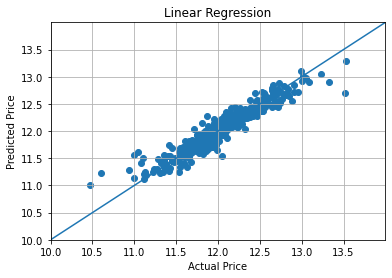

Number of erroneous predictions in final linear regression = 0


,Id,SalePrice
0,1461,114585.350489
1,1462,150141.124910
2,1463,172924.789987
3,1464,199746.452392
4,1465,208989.207471
...,...,...
1454,2915,79031.215763
1455,2916,78486.814469
1456,2917,153999.853403
1457,2918,115649.164802


In [17]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt
lr = linear_model.LinearRegression()

# Import train and test data, save train SalePrice and test Id separately, remove train SalePrice and train and test Id
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')
train.drop(['Id'], axis=1, inplace=True)
submission = test[['Id']]
test.drop(['Id'], axis=1, inplace=True)
train_sale_price = train[['SalePrice']]
train.drop(['SalePrice'], axis=1, inplace=True)

# Split features/columns into numerical and categorical lists
numeric_features_columns = list(train.select_dtypes(include=[np.number]).columns)
categorical_features_list_to_remove_from_numerical = ['MSSubClass', 'MoSold']
numeric_features_columns = list(set(numeric_features_columns) - set(categorical_features_list_to_remove_from_numerical))
train['MSSubClass'] = train['MSSubClass'].apply(str)
test['MSSubClass'] = test['MSSubClass'].apply(str)
train['MoSold'] = train['MoSold'].apply(str)
test['MoSold'] = test['MoSold'].apply(str)
categorical_features_columns = list(set(train.columns) - set(numeric_features_columns))

# The parameters we can change to alter the different components
categorical_parameter = .9 # Remove all categorical features which are dominated by a single category. More exactly, remove for which number_of_largest_category/total_number_of_house_data_points is > categorical_parameter and <= 1. If you want nothing removed, take > 1.
weak_correlations_paramenter = 0.05 # Remove all features whose train column is weakly correlated with train SalePrice. More exactly, remove for which the correlation is > -weak_correlation_parameter and  < +weak_correlation_parameter. If you want nothing removed, take < 0.
strong_correlations_paramenter = .8 # Remove 1 feature from all pairs of features when their train columns are strongly correlated. More exactly, remove 1 feature from all pairs of features when the correlation is > +strong_correlation_parameter and <= +1, or >= -1 and  < -strong_correlation_parameter. If you want nothing removed, take > 1.
outlier_salePrice_upper_bound = 2 # Remove train rows/house-data for which the scaled train salePrice is >= outlier_salePrice_upper_bound and <=1. If you want nothing removed, take > 1.
outlier_salePrice_lower_bound = -1 # Remove train rows/house-data for which the scaled train salePrice is >= 0 and <= outlier_salePrice_lower_bound. If you want nothing removed, take < 0.
far_from_typical_outliers_with_bounds = [
#     ('LotArea', 0.3),
#     ('LotFrontage', 0.65),
#     ('MasVnrArea', 0.85),
#     ('BsmtFinSF1', 0.35),
#     ('TotalBsmtSF', 0.5),
#     ('2ndFlrSF', 0.75),
#     ('1stFlrSF', 0.45),
#     ('GrLivArea', 0.8),
#     ('BsmtFullBath', .8),
#     ('TotRmsAbvGrd', 1),
#     ('GarageArea', 0.75),
#     ('OpenPorchSF', 0.75),
#     ('MiscVal', 0.25)
] # Remove, for example, train house data for which the scaled train LotArea is >= 0.3 and <= 1. Similarly for the other features in the list. If you want nothing removed, leave list blank. If you want more removed, add features to the list.

# Fill in the missing data
latest_year_house_sold = train['YrSold'].max()
train['GarageYrBlt'].fillna(latest_year_house_sold, inplace = True)
test['GarageYrBlt'].fillna(latest_year_house_sold, inplace = True)
train_numeric_features_with_missing_values = [feature for feature in numeric_features_columns if train[feature].isnull().sum() > 0]
test_numeric_features_with_missing_values = [feature for feature in numeric_features_columns if test[feature].isnull().sum() > 0]
train_categoric_features_with_missing_values = [feature for feature in categorical_features_columns if train[feature].isnull().sum() > 0]
test_categoric_features_with_missing_values = [feature for feature in categorical_features_columns if test[feature].isnull().sum() > 0]

for feature in train_numeric_features_with_missing_values:
    train[feature].fillna(0, inplace = True)

for feature in test_numeric_features_with_missing_values:
    test[feature].fillna(0, inplace = True)

categoric_features_with_NA = [
    'Alley',
    'BsmtCond',
    'BsmtExposure',
    'BsmtFinType1',
    'BsmtFinType2',
    'BsmtQual',
    'Fence',
    'FireplaceQu',
    'GarageCond',
    'GarageFinish',
    'GarageQual',
    'GarageType',
    'MiscFeature',
    'PoolQC'
]
for feature in train_categoric_features_with_missing_values:
    if feature in categoric_features_with_NA:
        train[feature].fillna('NA', inplace = True)
    else:
        train[feature].fillna(train[feature].value_counts().idxmax(), inplace = True)
        
for feature in test_categoric_features_with_missing_values:
    if feature in categoric_features_with_NA:
        test[feature].fillna('NA', inplace = True)
    else:
        test[feature].fillna(test[feature].value_counts().idxmax(), inplace = True)

# Convert year features to age features
year_features = ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold']
train['AgeOfHouse'] = train['YrSold'] - train['YearBuilt']
train['AgeOfRemodAdd'] = train['YrSold'] - train['YearRemodAdd']
train['AgeOfGarage'] = train['YrSold'] - train['GarageYrBlt']
train['AgeOfSale'] = latest_year_house_sold - train['YrSold']
test['AgeOfHouse'] = test['YrSold'] - test['YearBuilt']
test['AgeOfRemodAdd'] = test['YrSold'] - test['YearRemodAdd']
test['AgeOfGarage'] = test['YrSold'] - test['GarageYrBlt']
test['AgeOfSale'] = latest_year_house_sold - test['YrSold']
age_features = ['AgeOfHouse', 'AgeOfRemodAdd', 'AgeOfGarage', 'AgeOfSale']
train.drop(year_features, axis=1, inplace=True)
test.drop(year_features, axis=1, inplace=True)
numeric_features_columns = list(set(numeric_features_columns) - set(year_features))
numeric_features_columns = list(set(numeric_features_columns).union(set(age_features)))

print('After basic data preprocessing:')
print('Number of numeric features = ' + str(len(numeric_features_columns)))
print('Number of categorical features = ' + str(len(categorical_features_columns)))
print('')

# Define categorical features to transform to numerical, and the chosen numerical transformations. If you want nothing transformed, leave list blank. If you want more transformed, add features to the list, and a numerical transformation for that feature below.
categorical_features_to_convert_to_numerical = [
#     'Alley',
    'BsmtCond',
#     'BsmtExposure',
#     'BsmtFinType1',
#     'BsmtFinType2',
#     'BsmtQual',
#     'CentralAir',
    'ExterCond',
    'ExterQual',
#     'Fence',
    'FireplaceQu',
#     'Functional',
    'GarageCond',
#     'GarageFinish',
    'GarageQual',
    'HeatingQC',
    'KitchenQual',
#     'LandSlope',
#     'PavedDrive',
    'PoolQC'
#     'Street'
#     'Utilities'
]

def numerical_transformations(feature, x):
    if feature in ['ExterQual', 'ExterCond', 'HeatingQC', 'KitchenQual', 'PoolQC']:
        if x == 'Ex':
            return 4
        elif x == 'Gd':
            return 3
        elif x == 'TA':
            return 2
        elif x == 'Fa':
            return 1
        else:
            return 0

    if feature in ['BsmtCond', 'FireplaceQu', 'GarageQual', 'GarageCond']: 
        if x == 'Ex':
            return 5
        elif x == 'Gd':
            return 4
        elif x == 'TA':
            return 3
        elif x == 'Fa':
            return 2
        elif x == 'Po':
            return 1
        else:
            return 0

    if feature in ['BsmtFinType1', 'BsmtFinType2']:
        if x == 'GLQ':
            return 6
        elif x == 'ALQ':
            return 5
        elif x == 'BLQ':
            return 4
        elif x == 'Rec':
            return 3
        elif x == 'LwQ':
            return 2
        elif x == 'Unf':
            return 1
        else:
            return 0

    if feature == 'BsmtExposure':
        if x == 'Gd':
            return 4
        elif x == 'Av':
            return 3
        elif x == 'Mn':
            return 2
        elif x == 'No':
            return 1
        else:
            return 0

    if feature == 'Functional':
        if x == 'Typ':
            return 7
        elif x == 'Min1':
            return 6
        elif x == 'Min2':
            return 5
        elif x == 'Mod':
            return 4
        elif x == 'Maj1':
            return 3
        elif x == 'Maj2':
            return 2
        elif x == 'Sev':
            return 1
        else:
            return 0

    if feature == 'GarageFinish':
        if x == 'Fin':
            return 3
        elif x == 'RFn':
            return 2
        elif x == 'Unf':
            return 1
        else:
            return 0

    if feature == 'Fence':
        if x == 'GdPrv':
            return 4
        elif x == 'MnPrv':
            return 3
        elif x == 'GdWo':
            return 2
        elif x == 'MnWw':
            return 1
        else:
            return 0

    if feature == 'BsmtQual':
        if x == 'Ex':
            return 105
        elif x == 'Gd':
            return 95
        elif x == 'TA':
            return 85
        elif x == 'Fa':
            return 75
        elif x == 'Po':
            return 65
        else:
            return 0
        
    if feature == 'CentralAir':
        if x == 'Y':
            return 1
        else:
            return 0
        
    if feature == 'Street':
        if x == 'Pave':
            return 1
        else:
            return 0

    if feature == 'Alley':
        if x == 'Grvl' or x == 'Pave':
            return 1
        else:
            return 0

    if feature == 'LandSlope':
        if x == 'Gtl':
            return 1
        else:
            return 0
        
    if feature == 'PavedDrive':
        if x == 'Y' or x == 'P':
            return 1
        else:
            return 0
    
    if feature == 'Utilities':
        if x == 'AllPub':
            return 1
        else:
            return 0

# Transform the chosen categorical features using the numerical chosen transformations
for feature in categorical_features_to_convert_to_numerical:
    train[feature] = train[feature].apply(lambda x: numerical_transformations(feature, x))
    test[feature] = test[feature].apply(lambda x: numerical_transformations(feature, x))
    categorical_features_columns.remove(feature)
    numeric_features_columns.append(feature)
    
print('After numerical transformations of some categorical features:')
print('Number of numeric features = ' + str(len(numeric_features_columns)))
print('Number of categorical features = ' + str(len(categorical_features_columns)))
print('')

# Remove categorical features with too few unique entries
train_categorical_features_with_few_unique_entries = [feature for feature in categorical_features_columns if train[feature].value_counts()[0]/len(train.index) > categorical_parameter]
test_categorical_features_with_few_unique_entries = [feature for feature in categorical_features_columns if test[feature].value_counts()[0]/len(test.index) > categorical_parameter]
categorical_features_list_with_too_few_unique_entries = list(set(train_categorical_features_with_few_unique_entries).union(set(test_categorical_features_with_few_unique_entries)))
categorical_features_columns = list(set(categorical_features_columns) - set(categorical_features_list_with_too_few_unique_entries))
train.drop(categorical_features_list_with_too_few_unique_entries, axis=1, inplace=True)
test.drop(categorical_features_list_with_too_few_unique_entries, axis=1, inplace=True)

print('After removing categorical features with little information:')
print('Number of numeric features = ' + str(len(numeric_features_columns)))
print('Number of categorical features = ' + str(len(categorical_features_columns)))
print('')

# Replace categorical features with one-hot encoded dummy numerical features
def train_dummy_features_constructor(feature):
    return pd.get_dummies(train[feature]).rename(columns=lambda x: (feature + '_' + str(x)))

def test_dummy_features_constructor(feature):
    return pd.get_dummies(test[feature]).rename(columns=lambda x: (feature + '_' + str(x)))

for feature in categorical_features_columns:    
    train = pd.concat([train,train_dummy_features_constructor(feature)], axis=1)
    test = pd.concat([test,test_dummy_features_constructor(feature)], axis=1)
    train.drop([feature], axis=1, inplace=True)
    test.drop([feature], axis=1, inplace=True)
    
columns_in_train_but_not_test = list(set(train.columns) - set(test.columns))
columns_in_test_but_not_train = list(set(test.columns) - set(train.columns))
train.drop(columns_in_train_but_not_test, axis=1, inplace=True)
test.drop(columns_in_test_but_not_train, axis=1, inplace=True)

print('After replacing the categorical features with one-hot encoded features:')
print('Number of numeric features = ' + str(len(numeric_features_columns)))
print('Number of one-hot encoded categorical features = ' + str(train.shape[1]-len(numeric_features_columns)))
print('')

# Remove those features whose train column is weakly correlated with train SalePrice
features = list(train.columns)
train_correlations = pd.concat([train, train_sale_price['SalePrice']], axis=1).corr()

features_with_low_correlation_to_sale_price = [feature for feature in features if train_correlations[feature]['SalePrice'] < +weak_correlations_paramenter and train_correlations[feature]['SalePrice'] > -weak_correlations_paramenter] # All train featutes for which the correlation with train SalePrice is between -0.1 and +0.1.
numeric_features_columns = list(set(numeric_features_columns) - set(features_with_low_correlation_to_sale_price))
train.drop(features_with_low_correlation_to_sale_price, axis=1, inplace=True)
test.drop(features_with_low_correlation_to_sale_price, axis=1, inplace=True)

print('After removing features whose train column is weakly correlated with train SalePrice:')
print('Number of numeric features = ' + str(len(numeric_features_columns)))
print('Number of one-hot encoded categorical features = ' + str(train.shape[1]-len(numeric_features_columns)))
print('')

# Remove 1 feature from every pair of features whose train columns are strongly correlated
features = list(train.columns)
train_correlations = pd.concat([train, train_sale_price['SalePrice']], axis=1).corr()

feature_pairs_with_strong_correlation = []
features_from_each_strongly_correlated_pair_more_weakly_correlated_with_SalePrice = []

for feature1 in features:
    for feature2 in features[features.index(feature1)+1:]:
        if train_correlations[feature1][feature2] > +strong_correlations_paramenter or train_correlations[feature1][feature2] < -strong_correlations_paramenter:
            feature_pairs_with_strong_correlation.append([feature1, feature2])            
            if train_correlations[feature1]['SalePrice'] > train_correlations[feature2]['SalePrice']:
                features_from_each_strongly_correlated_pair_more_weakly_correlated_with_SalePrice.append(feature2)
            else:
                features_from_each_strongly_correlated_pair_more_weakly_correlated_with_SalePrice.append(feature1)


strongly_correlated_features_to_remove = list(set(features_from_each_strongly_correlated_pair_more_weakly_correlated_with_SalePrice))
numeric_features_columns = list(set(numeric_features_columns) - set(strongly_correlated_features_to_remove))
train.drop(strongly_correlated_features_to_remove, axis=1, inplace=True)
test.drop(strongly_correlated_features_to_remove, axis=1, inplace=True)

print('After removing 1 feature from every pair of features whose train columns are strongly correlated:')
print('Number of numeric features = ' + str(len(numeric_features_columns)))
print('Number of one-hot encoded categorical features = ' + str(train.shape[1]-len(numeric_features_columns)))
print('')

# Log transformation of train SalePrice
train_sale_price['SalePrice'] = train_sale_price['SalePrice'].apply(np.log)

# The dataframes on which we will perform the linear regression
X = train.copy()
Y = train_sale_price.copy()

# Create dataframe with the scaled train numeric features. All values are between 0 and 1 in this dataframe.
X_numeric_array = np.array(X[numeric_features_columns])
X_numeric_scaler = MinMaxScaler()
X_numeric_scaler.fit(X_numeric_array)
X_numeric_scaled = pd.DataFrame(X_numeric_scaler.transform(X_numeric_array), columns = numeric_features_columns)

# Create dataframe with the scaled train SalePrice. All values are between 0 and 1 in this dataframe.
Y_array = np.array(Y)
Y_scaler = MinMaxScaler()
Y_scaler.fit(Y_array)
Y_scaled = pd.DataFrame(Y_scaler.transform(Y_array), columns = ['SalePrice'])

# Train-test split
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=42, test_size=.33)
actual_log_prices = y_test
number_of_values_to_predict = actual_log_prices.shape[0]

print('Before removing train outlier rows/house-data:')
print('Number of train rows = ' + str(X.shape[0]))
print('')

# Remove outlier rows from X and Y, and from x_train and y_train, but not x_test and y_test.
Y = Y[Y_scaled['SalePrice'] < outlier_salePrice_upper_bound]
Y = Y[Y_scaled['SalePrice'] > outlier_salePrice_lower_bound]
X = X[X.index.isin(list(Y.index))]

print('After removing train SalePrice outlier rows:')
print('Number of train rows = ' + str(X.shape[0]))
print('')

for (feature, value_bound) in far_from_typical_outliers_with_bounds:
    if feature in list(X.columns): # This check is added as some features may have been removed above
        X = X[X_numeric_scaled[feature] < value_bound]
Y = Y[Y.index.isin(list(X.index))]

x_train = x_train[x_train.index.isin(list(X.index))]
y_train = y_train[y_train.index.isin(list(X.index))]

print('After removing "far from typical" train rows:')
print('Number of train rows = ' + str(X.shape[0]))
print('')

# Linear regression on train-test split
model = lr.fit(x_train, y_train)
predicted_log_prices = model.predict(x_test)
predicted_log_prices = pd.DataFrame(predicted_log_prices, columns = ['SalePrice'])

# It may happen that a small number of erroneous values are predicted due to calculation errors. If this happens we replace the erroneous values with the average house price
row_numbers_of_erroneous_predictions = list(predicted_log_prices[predicted_log_prices['SalePrice'] > 15].index) + list(predicted_log_prices[predicted_log_prices['SalePrice'] < 9].index)
print('Number of erroneous predictions in train-test split = ' + str(len(row_numbers_of_erroneous_predictions)))

for index in row_numbers_of_erroneous_predictions:
    predicted_log_prices['SalePrice'][index] = 0
predicted_log_prices.replace(0, predicted_log_prices['SalePrice'].mean(), inplace=True)

# Score and plot the train-test split
print('RMSE of train-test split = ' + str(np.sqrt(mean_squared_error(predicted_log_prices, actual_log_prices))))

fig = plt.figure()
ax = fig.gca()
ax.set_xticks(np.arange(10, 14, .5))
ax.set_yticks(np.arange(10, 14, .5))
plt.xlim(10,  14)
plt.ylim(10, 14)
plt.plot([10,14], [10,14])
plt.grid()
plt.scatter(actual_log_prices, predicted_log_prices)
plt.ylabel('Predicted Price')
plt.xlabel('Actual Price')
plt.title('Linear Regression')
plt.show()

# Linear regression on whole of X and Y
model = lr.fit(X, Y)
X_test = test.copy()
predicted_log_prices = model.predict(X_test)
predicted_log_prices = pd.DataFrame(predicted_log_prices, columns = ['SalePrice'])

# It may happen that a small number of erroneous values are predicted due to calculation errors. If this happens we replace the erroneous values with the average house price
row_numbers_of_erroneous_predictions = list(predicted_log_prices[predicted_log_prices['SalePrice'] > 15].index) + list(predicted_log_prices[predicted_log_prices['SalePrice'] < 9].index)
print('Number of erroneous predictions in final linear regression = ' + str(len(row_numbers_of_erroneous_predictions)))
for index in row_numbers_of_erroneous_predictions:
    predicted_log_prices['SalePrice'][index] = 0
predicted_log_prices.replace(0, predicted_log_prices['SalePrice'].mean(), inplace=True)

# Generate a kaggle submission file
submission['SalePrice'] = predicted_log_prices['SalePrice'].apply(np.exp)
submission.to_csv('submission_linear_regression_numerical_and_dummy_categorical.csv',index=False)

submission

Next we do a linear regression using only the numeric features, ignoring the one-hot encoded categorical features.

Number of erroneous predictions in train-test split = 0
RMSE of train-test split = 0.23020279681387987


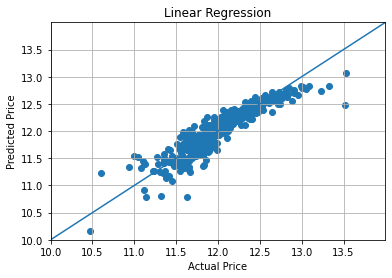

Number of erroneous predictions in final linear regression = 0


,Id,SalePrice
0,1461,112026.194645
1,1462,167890.610751
2,1463,170437.032370
3,1464,201587.838400
4,1465,207999.234898
...,...,...
1454,2915,91261.878755
1455,2916,76761.763282
1456,2917,179769.413079
1457,2918,108058.988455


In [15]:
# Restrict to the numeric features. Y and y_train and y_test are are unchanged from above
X = X[numeric_features_columns]
x_train = x_train[numeric_features_columns]
x_test = x_test[numeric_features_columns]

# Linear regression on train-test split
model = lr.fit(x_train, y_train)
predicted_log_prices = model.predict(x_test)
predicted_log_prices = pd.DataFrame(predicted_log_prices, columns = ['SalePrice'])

# It may happen that a small number of erroneous values are predicted due to calculation errors. If this happens we replace the erroneous values with the average house price
row_numbers_of_erroneous_predictions = list(predicted_log_prices[predicted_log_prices['SalePrice'] > 15].index) + list(predicted_log_prices[predicted_log_prices['SalePrice'] < 9].index)
print('Number of erroneous predictions in train-test split = ' + str(len(row_numbers_of_erroneous_predictions)))

for index in row_numbers_of_erroneous_predictions:
    predicted_log_prices['SalePrice'][index] = 0
predicted_log_prices.replace(0, predicted_log_prices['SalePrice'].mean(), inplace=True)

# Score and plot the train-test split
print('RMSE of train-test split = ' + str(np.sqrt(mean_squared_error(predicted_log_prices, actual_log_prices))))

fig = plt.figure()
ax = fig.gca()
ax.set_xticks(np.arange(10, 14, .5))
ax.set_yticks(np.arange(10, 14, .5))
plt.xlim(10,  14)
plt.ylim(10, 14)
plt.plot([10,14], [10,14])
plt.grid()
plt.scatter(actual_log_prices, predicted_log_prices)
plt.ylabel('Predicted Price')
plt.xlabel('Actual Price')
plt.title('Linear Regression')
plt.show()

# Linear regression on whole of X and Y
model = lr.fit(X, Y)
X_test = X_test[numeric_features_columns] # Restrict to the numeric feature
predicted_log_prices = model.predict(X_test)
predicted_log_prices = pd.DataFrame(predicted_log_prices, columns = ['SalePrice'])

# It may happen that a small number of erroneous values are predicted due to calculation errors. If this happens we replace the erroneous values with the average house price
row_numbers_of_erroneous_predictions = list(predicted_log_prices[predicted_log_prices['SalePrice'] > 15].index) + list(predicted_log_prices[predicted_log_prices['SalePrice'] < 9].index)
print('Number of erroneous predictions in final linear regression = ' + str(len(row_numbers_of_erroneous_predictions)))
for index in row_numbers_of_erroneous_predictions:
    predicted_log_prices['SalePrice'][index] = 0
predicted_log_prices.replace(0, predicted_log_prices['SalePrice'].mean(), inplace=True)

# Generate a kaggle submission file
submission['SalePrice'] = predicted_log_prices['SalePrice'].apply(np.exp)
submission.to_csv('submission_linear_regression_numerical_only.csv',index=False)

submission

We with the above code we now summarise the results of parts 4,5,6:

    Part 4: Categorical_parameter = 0.9, weak_correlations_paramenter = 0.05, strong_correlations_paramenter > 1, outlier_salePrice_upper_bound > 1, outlier_salePrice_lower_bound < 0, remove no far from typical outliers. Linear regression gives RMSE 0.13864 for numerical and one-hot encoded, and RMSE 0.14517 for only numerical.
    
    Part 4: Categorical_parameter = 0.9, weak_correlations_paramenter = 0.1, strong_correlations_paramenter > 1, outlier_salePrice_upper_bound > 1, outlier_salePrice_lower_bound < 0, remove no far from typical outliers. . Linear regression gives RMSE 0.14157 for numerical and one-hot encoded, and RMSE 0.14997 for only numerical.
    
    Part 5: Categorical_parameter = 0.9, weak_correlations_paramenter < 0, strong_correlations_paramenter = 0.8, outlier_salePrice_upper_bound > 1, outlier_salePrice_lower_bound < 0, remove no far from typical outliers. Linear regression gives RMSE 0.14176 for numerical and one-hot encoded, and RMSE 0.14466 for only numerical.
    
    Part 5: Categorical_parameter = 0.9, weak_correlations_paramenter < 0, strong_correlations_paramenter = 0.85, outlier_salePrice_upper_bound > 1, outlier_salePrice_lower_bound < 0, remove no far from typical outliers. Linear regression gives RMSE 0.14220 for numerical and one-hot encoded, and RMSE 0.14463 for only numerical.
    
    Part 6: Categorical_parameter = 0.9, weak_correlations_paramenter < 0, strong_correlations_paramenter > 1, outlier_salePrice_upper_bound = 0.85, outlier_salePrice_lower_bound = 0.15, remove no far from typical outliers. Linear regression gives RMSE 0.14110 for numerical and one-hot encoded, and RMSE 0.15117 for only numerical.
    
    Part 6: Categorical_parameter = 0.9, weak_correlations_paramenter < 0, strong_correlations_paramenter > 1, outlier_salePrice_upper_bound > 1, outlier_salePrice_lower_bound < 0, remove all far from typical outliers. Linear regression gives RMSE 0.13822 for numerical and one-hot encoded, and RMSE 0.14234 for only numerical.


**Final linear regressions**

Here are some more linear regression results with the above code.

    Categorical_parameter > 1, weak_correlations_paramenter = 0.05, strong_correlations_paramenter = 0.8, outlier_salePrice_upper_bound > 1, outlier_salePrice_lower_bound < 0, remove no far from typical outliers. Linear regression gives RMSE 0.13809 for numerical and one-hot encoded, and RMSE 0.14424 for only numerical.
    
    Categorical_parameter = 0.9, weak_correlations_paramenter = 0.05, strong_correlations_paramenter = 0.8, outlier_salePrice_upper_bound > 1, outlier_salePrice_lower_bound < 0, remove no far from typical outliers. Linear regression gives RMSE 0.13742 for numerical and one-hot encoded, and RMSE 0.14424 for only numerical.
    
    Categorical_parameter = 0.9, weak_correlations_paramenter = 0.05, strong_correlations_paramenter = 0.8, outlier_salePrice_upper_bound = 0.85, outlier_salePrice_lower_bound = 0.15, remove no far from typical outliers. Linear regression gives RMSE 0.13684 for numerical and one-hot encoded, and RMSE 0.14706 for only numerical.
    
    Categorical_parameter = 0.9, weak_correlations_paramenter = 0.05, strong_correlations_paramenter = 0.8, outlier_salePrice_upper_bound > 1, outlier_salePrice_lower_bound < 0, remove all far from typical outliers. Linear regression gives RMSE 0.13684 for numerical and one-hot encoded, and RMSE 0.14706 for only numerical.

    Categorical_parameter = 0.9, weak_correlations_paramenter = 0.05, strong_correlations_paramenter = 0.8, outlier_salePrice_upper_bound = 0.85, outlier_salePrice_lower_bound = 0.15, remove all far from typical outliers. Linear regression gives RMSE 0.13670 for numerical and one-hot encoded, and RMSE 0.14359 for only numerical.
    
    Categorical_parameter = 0.9, weak_correlations_paramenter = 0.05, strong_correlations_paramenter = 0.8, outlier_salePrice_upper_bound > 1, outlier_salePrice_lower_bound < 0, remove no far from typical outliers. Do not numerically transform all the features in the list, removing only ['BsmtCond', 'ExterCond', 'ExterQual', 'FireplaceQu', 'GarageCond', 'GarageQual', 'HeatingQC', 'KitchenQual', 'PoolQC']. Linear regression gives RMSE 0.13791 for numerical and one-hot encoded, and RMSE 0.14617 for only numerical.
    
    Categorical_parameter = 0.9, weak_correlations_paramenter = 0.05, strong_correlations_paramenter = 0.8, outlier_salePrice_upper_bound = 0.85, outlier_salePrice_lower_bound = 0.15, remove all far from typical outliers. Do not numerically transform all the features in the list, removing only ['BsmtCond', 'ExterCond', 'ExterQual', 'FireplaceQu', 'GarageCond', 'GarageQual', 'HeatingQC', 'KitchenQual', 'PoolQC']. Linear regression gives RMSE 0.14565 for numerical and one-hot encoded, and RMSE 0.14617 for only numerical.
    
**Possible Improvements**

The best result obtained above was 0.13670. Some obvious possible ways to attempt to improve this are the following:

    1. Fill in the missing data in a different way, for example with median instead of 0.
    2. Numerically transform different categorical variables, or use different numerical transformations.
    3. Change the different parameters for the removal of categorical features with few unique entries, weakly correlations, strong correlations, and outliers.
    
Some less obvious ways:
    
    1. Instead of simply dropping categorical features with few unique entries, and before one-hot encoding, examine all categorical features more closely, and transform them into more suitable categorical features. For example, it may be appropriate to concatenate several like categories.
    2. Before dropping a feature with weak correlation, try to determine if the SalePrice is indeed not dependent on this feature. For example, you could just make an educated guess based on the feature description. If you are not convinced of this, dropping the feature may not be appropriate. Similarly try to determine if strongly correlated features are indeed dependent.
    3. Instead of simply dropping features with weak or strong correlations, use feature engineering to try to construct more suitable features. For example, it may be appropriate to take the mean of 2 features with strong correlations.
    4. Do not log transform the train SalePrice, or use a different transform. You can also try to transform some features in a similar way.
    5. Investigate outliers in other ways, for example using random forests.
    
We will not attempt to do the above, and leave linear regression at the point. We instead move onto DNN regression.